# Introduction to Bayesian Neural Networks

# Import dependent libraries

In [23]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

from tqdm import tqdm
from matplotlib import figure 
from matplotlib.backends import backend_agg
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Part 01 -- Air quality prediction
Predict the groundtruth air pollutant levels using estimated values from a set of metal oxide sensors.


#### [More about the dataset](http://archive.ics.uci.edu/ml/datasets/Air+Quality)

In [ ]:
tf.keras.backend.set_floatx("float64")

In [ ]:
tfk=tf.keras
tfd=tfp.distributions

In [ ]:
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,
                           behaviour="deprecated",
                           contamination="auto",
                           random_state=0)
neg_log_likelihood=lambda x,rv_x:-rv_x.log_prob(x)

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
!unzip -q ./Air*.zip

In [ ]:
data=pd.read_excel('/content/AirQualityUCI.xlsx')
data=data[data['Date']<='2004-09-10']

In [ ]:
columns=['PT08.S1(CO)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','T','AH','CO(GT)','C6H6(GT)','NOx(GT)','NO2(GT)']
data=data[columns].dropna(axis=0)

In [ ]:
X_t=scaler.fit_transform(data)

In [ ]:
is_inlier=detector.fit_predict(X_t)
X_t=X_t[(is_inlier > 0),:]

In [ ]:
dataset=pd.DataFrame(X_t,columns=columns)

In [ ]:
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

In [ ]:
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

In [ ]:
n_train = int(0.7*dataset.shape[0])

In [ ]:
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [ ]:
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

In [ ]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), 
                                                dtype=tf.float64), 
                                   scale=1.0), 
                        reinterpreted_batch_ndims=1)


In [ ]:
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")

In [ ]:
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [ ]:
model.fit(data_train, 
          epochs=n_epochs, 
          validation_data=data_test, 
          verbose=True)

In [ ]:
model.summary()

In [ ]:
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

In [ ]:
samples=500
iterations=10
test_iterator=iter(data_test)
(X_true,Y_true,Y_pred)=(np.empty(shape=(samples,len(inputs))),
                        np.empty(shape=(samples,len(outputs))),
                        np.empty(shape=(samples,len(outputs),iterations)))
for i in tqdm(range(samples)):
  features,labels=test_iterator.get_next()
  X_true[i,:]=features
  Y_true[i,:]=labels.numpy()
  for k in range(iterations):
    Y_pred[i,:,k]=model.predict(features)
  model.evaluate(features)

In [ ]:
Y_pred_m=np.mean(Y_pred,axis=-1)
Y_pred_s=np.std(Y_pred,axis=-1)

# Part 02 -- Bayesian MNIST classifier

In [2]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()

Image label: 8


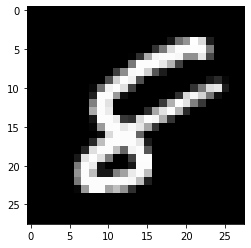

In [3]:
img_no=485
one_image=x_train[img_no]
plt.imshow(one_image,cmap='gist_gray')
print('Image label: {}'.format(y_train[img_no]))

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train =x_train/255.0
x_train=x_train.reshape(-1,28,28,1)
y_train=tf.keras.utils.to_categorical(y_train,num_classes=10)

In [6]:
inputs_seq=tf.keras.layers.Input(shape=(28,28,1),name='MNIST_input')
dropout_rate=0.25

In [7]:
x=tf.keras.layers.Conv2D(32, kernel_size=5, padding='SAME', activation=tf.nn.relu)(inputs_seq)
x=tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x=tf.keras.layers.Conv2D(64, kernel_size=5, padding='SAME', activation=tf.nn.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024,activation=tf.nn.relu)(x)
x=tf.keras.layers.Dropout(dropout_rate)(x)
y=tf.keras.layers.Dense(10)(x)

In [8]:
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train,
                                                                     logits=y))
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [9]:
def build_bayesian_model(input_shape):
  model_in = tf.keras.layers.Input(shape=input_shape)
  conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3,3), padding="same", strides=2)
  x = conv_1(model_in)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3,3), padding="same", strides=2)
  x = conv_2(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Flatten()(x)
  dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
  x = dense_1(x)
  dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
  model_out = dense_2(x)  # logits
  model = tf.keras.Model(model_in, model_out)
  return model

In [10]:
@tf.function
def elbo_loss(labels,logits):
  loss_en=tf.nn.softmax_cross_entropy_with_logits(labels,logits)
  loss_kl=tf.keras.losses.KLD(labels, logits)
  loss=tf.reduce_mean(tf.add(loss_en, loss_kl))
  return loss

In [11]:
# @tf.function
# def elbo_loss(y_preds,y_train):
#   kl=sum(bayesian_model.losses)/len(x_train)
#   labels_distribution=tfp.distributions.Categorical(logits=y_preds)
#   neg_log_likelihood=-tf.reduce_mean(labels_distribution.log_prob(y_train))
#   return neg_log_likelihood+kl

In [12]:
@tf.function
def train_model(images,labels,model):
  with tf.GradientTape() as tape:
      logits=model(images)
      loss=elbo_loss(labels,logits)
  gradients=tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  return loss

def accuracy(preds, labels):
  return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

In [19]:
bayesian_model=build_bayesian_model((28,28,1))
optimizer=tf.keras.optimizers.Adam(lr=0.01)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [24]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.3,random_state=42)

In [25]:
times=[]
accs=[]
val_accs=[]
losses=[]
val_losses=[]
for i in range(20):
  start=time.time()
  loss=train_model(x_train,y_train,bayesian_model)
  preds=bayesian_model(x_train)
  acc=accuracy(preds, y_train)
  accs.append(acc)
  losses.append(loss)
    
  val_preds=bayesian_model(x_val)
  val_loss=elbo_loss(y_val, val_preds)
  val_acc=accuracy(y_val, val_preds)
    
  val_accs.append(val_acc)
  val_losses.append(val_loss)
  end=time.time()
  train_time=end-start
  times.append(train_time)
    
  print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))

Epoch: 0: loss =  10.360 , accuracy =   0.184, val_loss =   7.016, val_acc=  0.188 time:  56.899
Epoch: 1: loss =   6.917 , accuracy =   0.252, val_loss =   4.227, val_acc=  0.256 time:  56.218
Epoch: 2: loss =   4.278 , accuracy =   0.185, val_loss =   2.501, val_acc=  0.184 time:  56.000
Epoch: 3: loss =   2.508 , accuracy =   0.193, val_loss =   2.224, val_acc=  0.208 time:  55.794
Epoch: 4: loss =   2.249 , accuracy =   0.258, val_loss =   2.058, val_acc=  0.272 time:  55.887
Epoch: 5: loss =   2.078 , accuracy =   0.381, val_loss =   1.875, val_acc=  0.381 time:  55.968
Epoch: 6: loss =   1.864 , accuracy =   0.492, val_loss =   1.656, val_acc=  0.501 time:  56.049
Epoch: 7: loss =   1.673 , accuracy =   0.607, val_loss =   1.401, val_acc=  0.598 time:  56.261
Epoch: 8: loss =   1.399 , accuracy =   0.678, val_loss =   1.116, val_acc=  0.678 time:  55.868
Epoch: 9: loss =   1.136 , accuracy =   0.685, val_loss =   1.009, val_acc=  0.682 time:  55.626
Epoch: 10: loss =   0.992 , ac

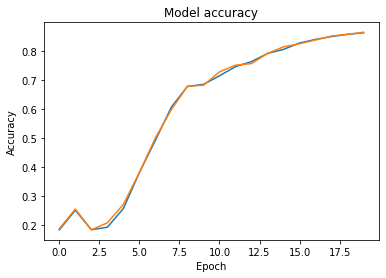

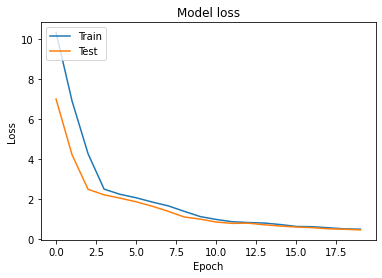

In [26]:
plt.plot(np.array(accs), label="acc")
plt.plot(np.array(val_accs), label="val_acc")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(np.array(losses), label="loss")
plt.plot(np.array(val_losses), label="val_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
def plot_pred_hist(y_pred,n_class,n_mc_run,n_bins=30,med_prob_thres=0.2,n_subplot_rows=2,figsize=(25, 10)):
  bins = np.logspace(-n_bins, 0, n_bins+1)
  fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
  for i in range(n_subplot_rows):
    for j in range(n_class // n_subplot_rows + 1):
      idx = i * (n_class // n_subplot_rows + 1) + j
      if idx < n_class:
        ax[i, j].hist(y_pred[idx], bins)
        ax[i, j].set_xscale('log')
        ax[i, j].set_ylim([0, n_mc_run])
        ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                              np.median(y_pred[idx]),
                                                                              str(np.median(y_pred[idx]) >= med_prob_thres)))
      else:
        ax[i, j].axis('off')
  plt.show()

In [30]:
n_mc_run=50
med_prob_thres=0.35
y_pred_logits_list=[bayesian_model(x_val) for _ in tqdm(range(n_mc_run))]  # a list of predicted logits
y_pred_prob_all=np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred=[[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred=np.array(y_pred)

100%|██████████| 50/50 [05:27<00:00,  6.54s/it]


In [32]:
idx_valid=[any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))
idx_invalid=[not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])
print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_val[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_val[idx_valid]))
print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_val[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_val[idx_invalid]))

Number of recognizable samples: 17709
Unrecognizable samples: [   42   142   217   288   343   406   486   557   624   642   673   677
   752   763   911   952  1032  1184  1196  1225  1302  1394  1440  1483
  1659  1707  1756  1858  1908  1994  2018  2071  2217  2246  2277  2280
  2291  2309  2354  2368  2454  2534  2674  2782  2867  2879  2916  2923
  2964  2988  3056  3065  3093  3148  3210  3294  3311  3326  3499  3561
  3602  3606  3672  3676  3690  3692  3811  3865  3903  3912  4002  4071
  4075  4180  4195  4235  4283  4438  4506  4508  4529  4699  4721  4735
  4742  4796  5054  5082  5270  5504  5627  5652  5658  5722  5728  5768
  5804  5885  5947  6023  6036  6077  6244  6339  6520  6586  6729  6730
  6754  6800  6801  6819  6831  6883  6903  6936  6979  7036  7199  7268
  7622  7628  7637  7685  7707  7812  7834  7903  7935  8004  8006  8027
  8069  8124  8221  8272  8280  8386  8400  8464  8470  8505  8539  8563
  8566  8603  8605  8670  8680  8758  8770  8785  8846  8872  

True label of the test sample 0: 7


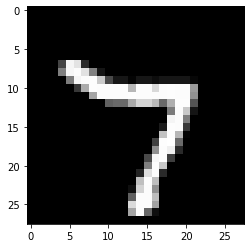

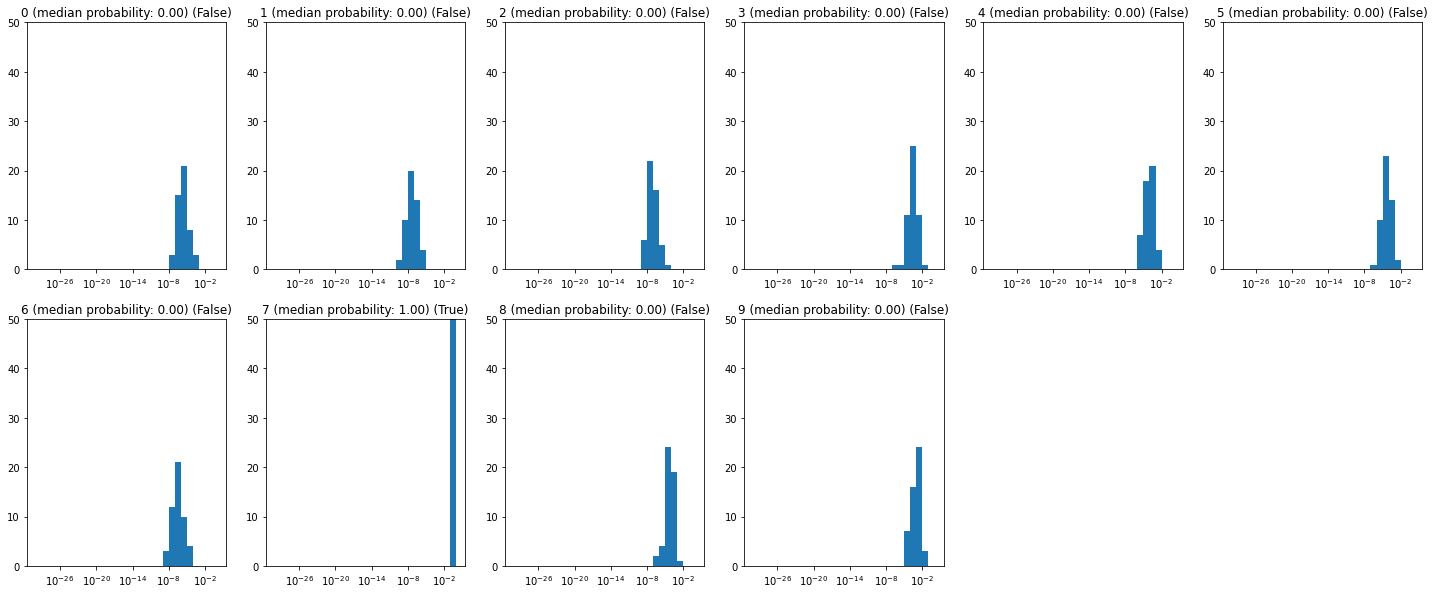

In [34]:
class_size=10
plt.imshow(x_val[0, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(y_val[0], axis=-1)))
plot_pred_hist(y_pred_prob_all[0], class_size, n_mc_run, med_prob_thres=med_prob_thres)

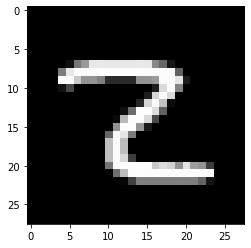

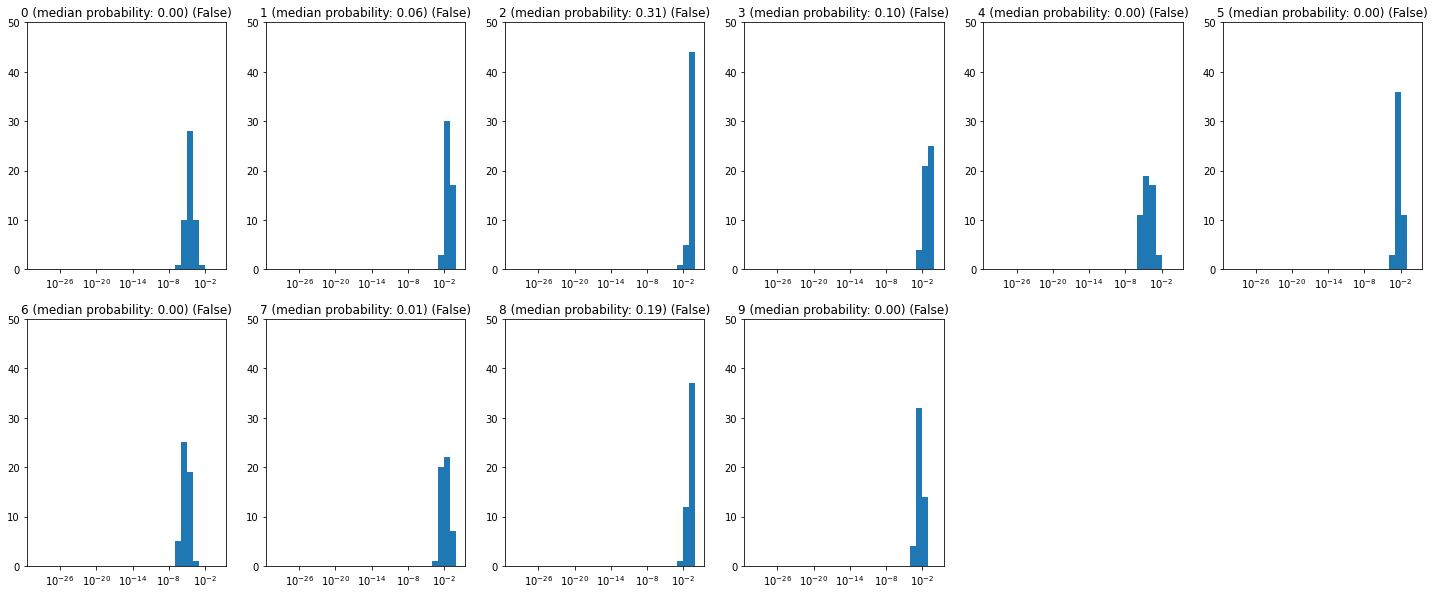

True label of test image 42: 2
High uncertainty in recognizing the image. Likely label: 2 ...




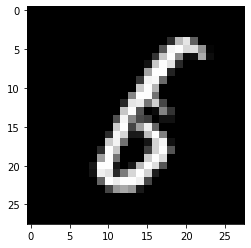

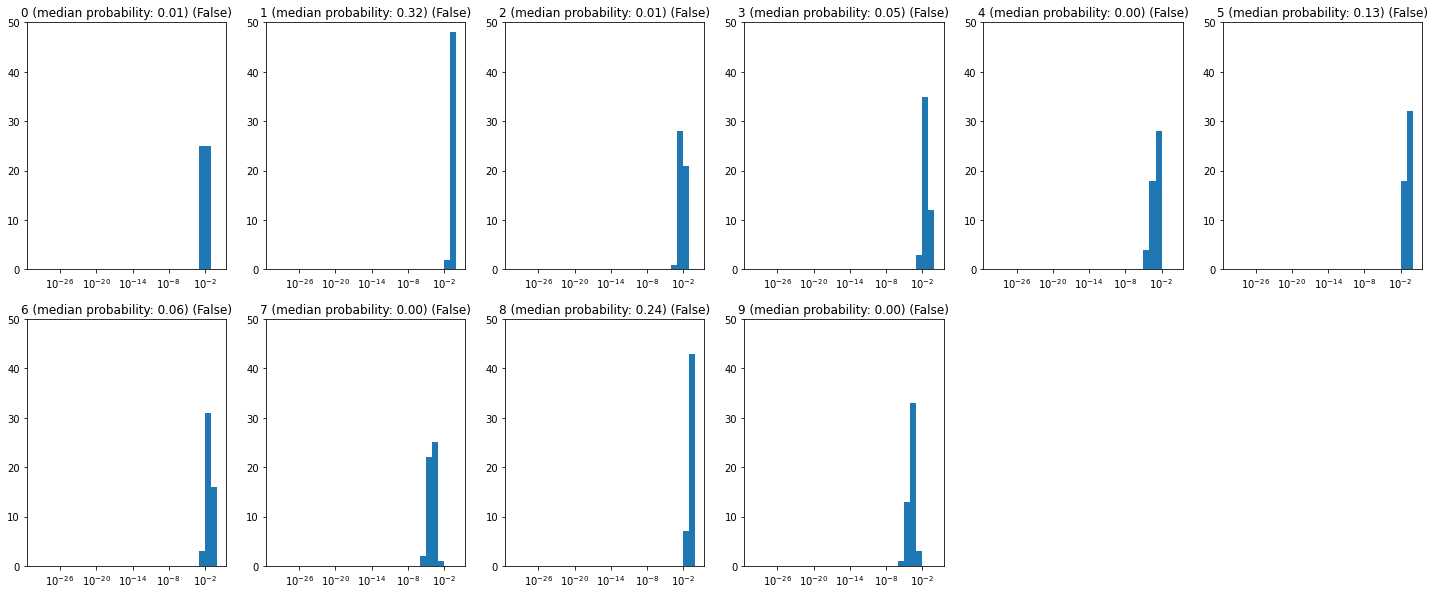

True label of test image 142: 6
High uncertainty in recognizing the image. Likely label: 1 ...




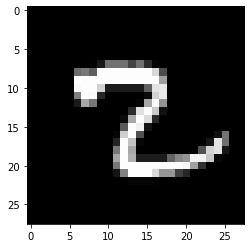

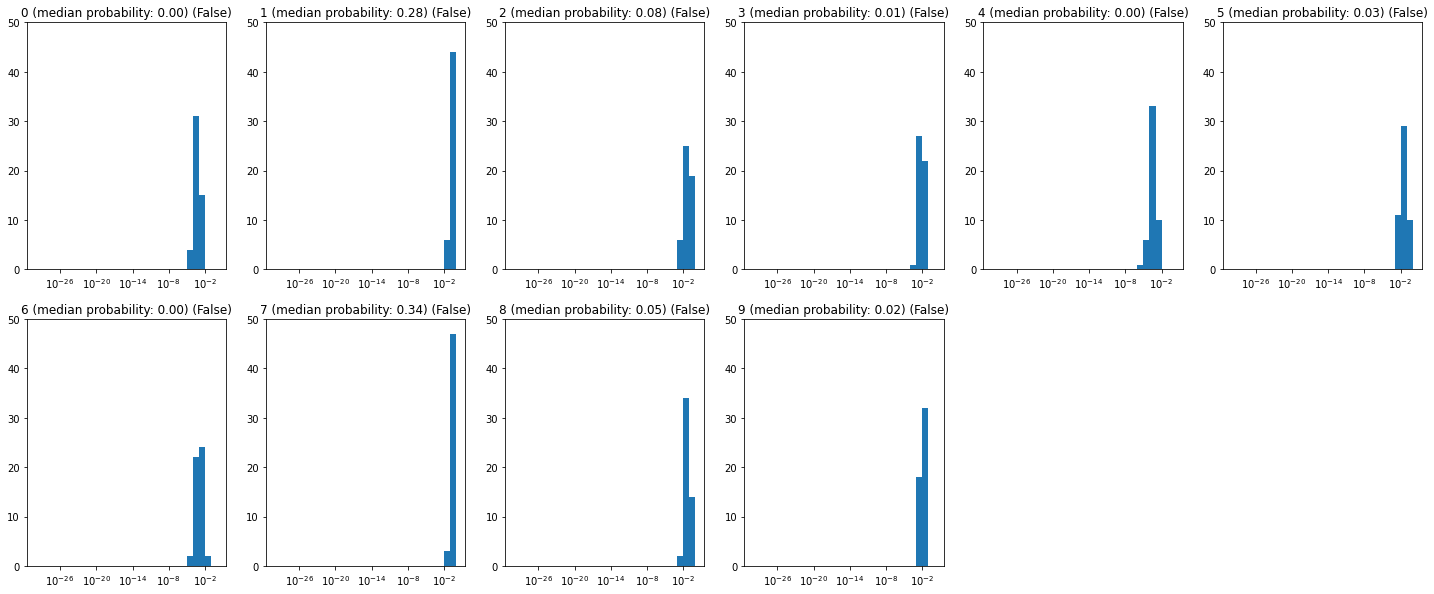

True label of test image 217: 2
High uncertainty in recognizing the image. Likely label: 7 ...




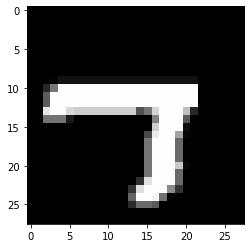

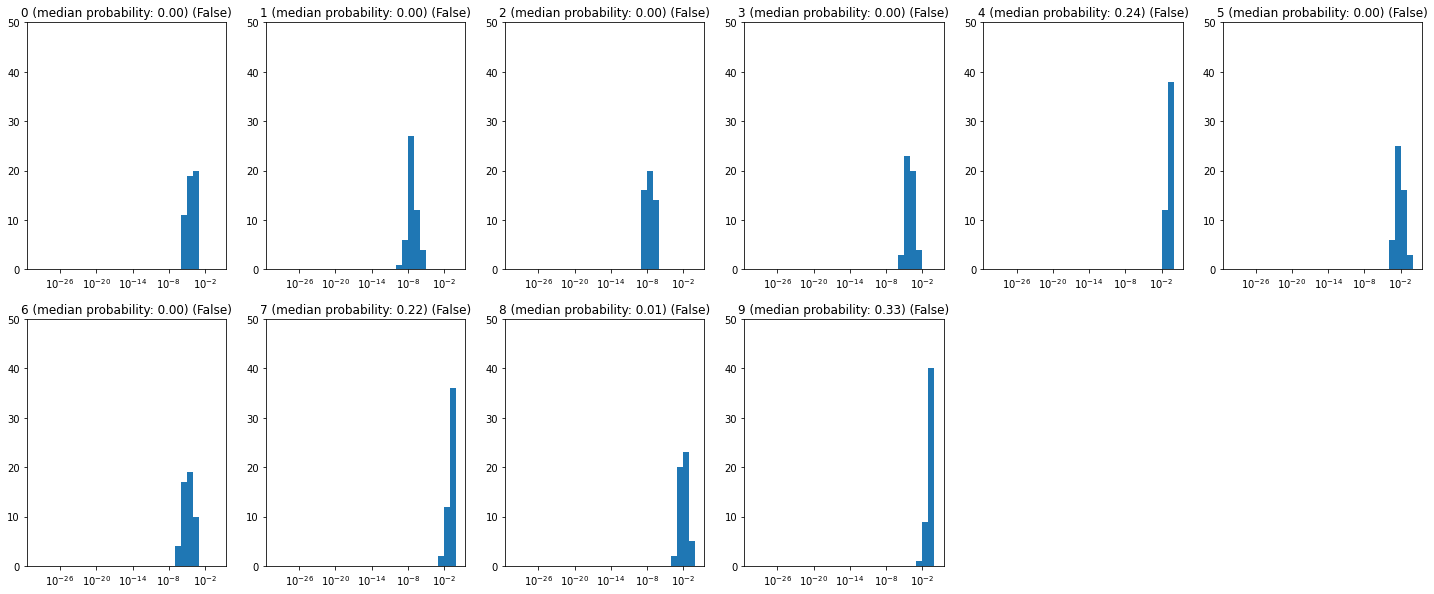

True label of test image 288: 7
High uncertainty in recognizing the image. Likely label: 9 ...




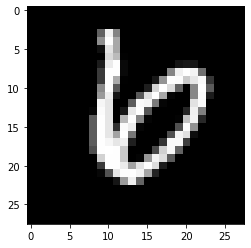

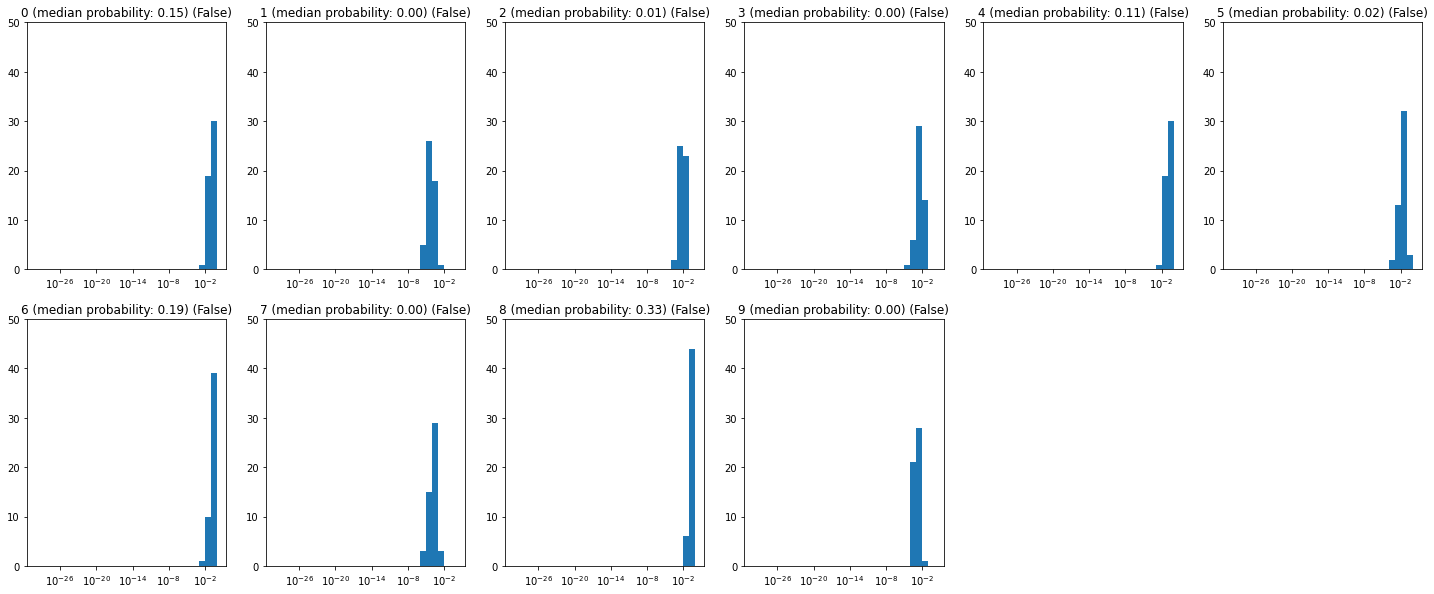

True label of test image 343: 6
High uncertainty in recognizing the image. Likely label: 8 ...




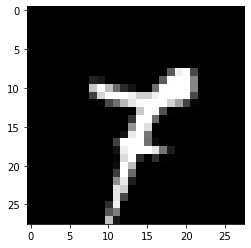

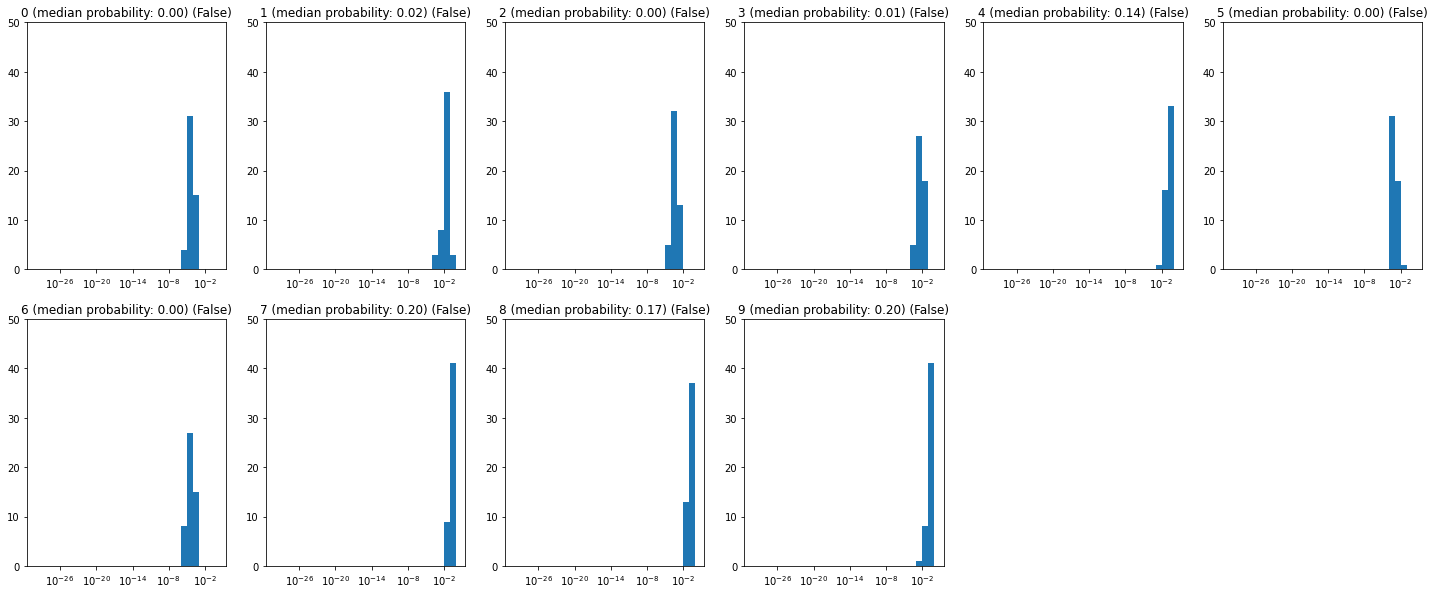

True label of test image 406: 7
High uncertainty in recognizing the image. Likely label: 7 ...




In [47]:
class_size=10
num_invalids=0
for idx in np.where(idx_invalid)[0]:
  plt.imshow(x_val[idx,:,:,0],cmap='gist_gray')
  print('=============================================================================')
  plot_pred_hist(y_pred_prob_all[idx],class_size,n_mc_run,med_prob_thres=med_prob_thres)
  print("True label of test image {}: {}".format(idx,np.argmax(y_val[idx],axis=-1)))
  if any(y_pred[idx]):
    print("Predicted label of the test image {}: {}".format(idx,np.argmax(y_pred[idx],axis=-1)))
  else:
    print("High uncertainty in recognizing the image. Likely label: {} ...".format(np.argmax(np.mean(y_pred_prob_all[idx][:],axis=-1))))
    print('\n')
  num_invalids+=1
  if num_invalids > 5:
      break